# MMSE Estimation

Major theorem verification: $\hat{\mathbf{x}} = \boldsymbol{\mu}_x + \mathbf{K}_{xy}\mathbf{K}_{yy}^{-1}(\mathbf{y} - \boldsymbol{\mu}_y)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import multivariate_normal
import seaborn as sns

# Modern matplotlib style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
np.random.seed(42)

## MMSE Implementation

The MMSE estimator for jointly Gaussian $(\mathbf{x}, \mathbf{y})$ has the closed-form solution:

$$\hat{\mathbf{x}} = \boldsymbol{\mu}_x + \mathbf{K}_{xy}\mathbf{K}_{yy}^{-1}(\mathbf{y} - \boldsymbol{\mu}_y)$$

The orthogonality principle guarantees that $\mathbb{E}[(\mathbf{x} - \hat{\mathbf{x}})\mathbf{y}^T] = \mathbf{0}$. When the Gaussian assumption fails, the linear estimator remains the best within the class of all linear estimators.

In [2]:
class GaussianMMSE:
    """MMSE estimator: x̂ = μ_x + K_xy K_yy^(-1) (y - μ_y)"""
    
    def __init__(self, mu_x, mu_y, K_xx, K_yy, K_xy):
        self.mu_x = np.array(mu_x)
        self.mu_y = np.array(mu_y)
        self.K_xx = np.array(K_xx)
        self.K_yy = np.array(K_yy)
        self.K_xy = np.array(K_xy)
        
        # Precompute MMSE gain matrix
        self.A_mmse = self.K_xy @ np.linalg.inv(self.K_yy)
        
        # Error covariance
        self.K_error = self.K_xx - self.A_mmse @ self.K_xy.T
        
        # Minimum achievable MSE
        self.mse_min = np.trace(self.K_error)
    
    def estimate(self, y):
        """MMSE estimate"""
        y = np.atleast_1d(y)
        return self.mu_x + self.A_mmse @ (y - self.mu_y)
    
    def verify_orthogonality(self, X_samples, Y_samples):
        """Orthogonality: E[(x - x̂)y^T] = 0"""
        X_hat = np.array([self.estimate(y) for y in Y_samples])
        errors = X_samples - X_hat
        
        # Check orthogonality
        cross_corr = np.mean(errors[:, :, np.newaxis] * Y_samples[:, np.newaxis, :], axis=0)
        return cross_corr
    
    def sample_joint(self, n_samples):
        """Joint samples"""
        # Joint mean and covariance
        mu_joint = np.concatenate([self.mu_x, self.mu_y])
        
        K_joint = np.block([
            [self.K_xx, self.K_xy],
            [self.K_xy.T, self.K_yy]
        ])
        
        samples = np.random.multivariate_normal(mu_joint, K_joint, n_samples)
        
        n_x = len(self.mu_x)
        X_samples = samples[:, :n_x]
        Y_samples = samples[:, n_x:]
        
        return X_samples, Y_samples

## Parameter Effects

The correlation structure between $\mathbf{x}$ and $\mathbf{y}$ determines MMSE performance. Strong correlation (large $|\rho|$) enables accurate estimation, while noise variance controls the fundamental limits. 

The gain matrix $\mathbf{A}^* = \mathbf{K}_{xy}\mathbf{K}_{yy}^{-1}$ automatically balances signal extraction against noise amplification.

In [3]:
def interactive_mmse_demo():
    """Interactive widgets for exploring MMSE properties"""
    
    # Widget controls
    correlation_slider = widgets.FloatSlider(
        value=0.7, min=-0.95, max=0.95, step=0.05,
        description='Correlation ρ:', style={'description_width': 'initial'}
    )
    
    noise_var_slider = widgets.FloatSlider(
        value=0.5, min=0.1, max=2.0, step=0.1,
        description='Noise Variance:', style={'description_width': 'initial'}
    )
    
    n_samples_slider = widgets.IntSlider(
        value=500, min=50, max=1000, step=50,
        description='# Samples:', style={'description_width': 'initial'}
    )
    
    def update_plot(correlation, noise_var, n_samples):
        # Set up problem parameters
        mu_x = np.array([0, 0])
        mu_y = np.array([0, 0])
        
        # X covariance (identity)
        K_xx = np.eye(2)
        
        # Cross-covariance (controls correlation)
        K_xy = correlation * np.eye(2)
        
        # Y covariance (signal + noise)
        K_yy = K_xx + noise_var * np.eye(2)
        
        # Create MMSE estimator
        mmse = GaussianMMSE(mu_x, mu_y, K_xx, K_yy, K_xy)
        
        # Generate samples
        X_samples, Y_samples = mmse.sample_joint(n_samples)
        
        # Compute estimates
        X_hat = np.array([mmse.estimate(y) for y in Y_samples])
        
        # Create plots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # 1. Joint distribution
        ax = axes[0, 0]
        ax.scatter(Y_samples[:, 0], X_samples[:, 0], alpha=0.5, s=20, label='Samples')
        ax.set_xlabel('y₁')
        ax.set_ylabel('x₁')
        ax.set_title('Joint Distribution')
        ax.grid(True, alpha=0.3)
        
        # 2. Estimation performance
        ax = axes[0, 1]
        ax.scatter(X_samples[:, 0], X_hat[:, 0], alpha=0.5, s=20)
        lims = [ax.get_xlim(), ax.get_ylim()]
        lims = [min(lims[0][0], lims[1][0]), max(lims[0][1], lims[1][1])]
        ax.plot(lims, lims, 'r--', alpha=0.8, label='Perfect estimation')
        ax.set_xlabel('True x₁')
        ax.set_ylabel('Estimated x̂₁')
        ax.set_title(f'Estimation Quality (MSE: {np.mean((X_samples - X_hat)**2):.3f})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Error analysis
        errors = X_samples - X_hat
        ax = axes[0, 2]
        ax.hist(errors[:, 0], bins=30, density=True, alpha=0.7, edgecolor='black')
        ax.axvline(np.mean(errors[:, 0]), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(errors[:, 0]):.3f}')
        ax.set_xlabel('Error (x₁ - x̂₁)')
        ax.set_ylabel('Density')
        ax.set_title('Error Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Orthogonality verification
        ax = axes[1, 0]
        ax.scatter(Y_samples[:, 0], errors[:, 0], alpha=0.5, s=20)
        ax.axhline(0, color='red', linestyle='--')
        corr_coef = np.corrcoef(Y_samples[:, 0], errors[:, 0])[0, 1]
        ax.set_xlabel('y₁')
        ax.set_ylabel('Error (x₁ - x̂₁)')
        ax.set_title(f'Orthogonality Check (Corr: {corr_coef:.4f})')
        ax.grid(True, alpha=0.3)
        
        # 5. Theoretical vs empirical
        ax = axes[1, 1]
        empirical_mse = np.mean((X_samples - X_hat)**2)
        theoretical_mse = mmse.mse_min
        
        ax.bar(['Theoretical\nMinimum', 'Empirical\nMSE'], 
               [theoretical_mse, empirical_mse],
               color=['blue', 'orange'], alpha=0.7)
        ax.set_ylabel('MSE')
        ax.set_title('Theory vs Practice')
        ax.grid(True, alpha=0.3, axis='y')
        
        # 6. Covariance matrices
        ax = axes[1, 2]
        matrices = [mmse.K_xx, mmse.K_xy, mmse.K_yy, mmse.K_error]
        labels = ['K_xx', 'K_xy', 'K_yy', 'K_error']
        
        info_text = f"""Problem Setup:
• Correlation: {correlation:.2f}
• Noise Var: {noise_var:.2f}
• Samples: {n_samples}

MMSE Results:
• Min MSE: {theoretical_mse:.3f}
• Empirical: {empirical_mse:.3f}
• Error Corr: {corr_coef:.4f}

Gain Matrix A:
{mmse.A_mmse}"""
        
        ax.text(0.05, 0.95, info_text, transform=ax.transAxes, 
               verticalalignment='top', fontfamily='monospace', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Create interactive widget
    interactive_plot = widgets.interactive(
        update_plot,
        correlation=correlation_slider,
        noise_var=noise_var_slider,
        n_samples=n_samples_slider
    )
    
    display(interactive_plot)

# Run the interactive demo
interactive_mmse_demo()

interactive(children=(FloatSlider(value=0.7, description='Correlation ρ:', max=0.95, min=-0.95, step=0.05, sty…

## Sample Convergence

Sample covariances converge to population values as $N \to \infty$. The MSE estimation error follows $O(1/N)$, while the gain matrix error follows $O(1/\sqrt{N})$ - consistent with central limit theorem predictions.

For finite samples, the estimated MMSE filter $\hat{\mathbf{A}} = \hat{\mathbf{K}}_{xy}\hat{\mathbf{K}}_{yy}^{-1}$ approaches the optimal $\mathbf{A}^* = \mathbf{K}_{xy}\mathbf{K}_{yy}^{-1}$.

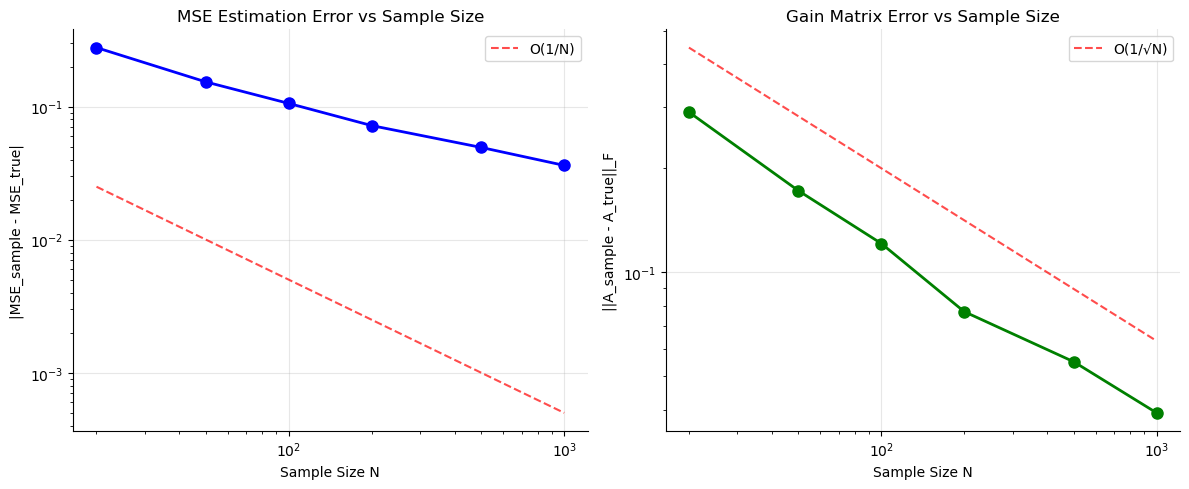

True minimum MSE: 1.3221
True gain matrix A:
[[0.39464883 0.10702341]
 [0.02006689 0.59866221]]


In [4]:
def sample_size_analysis():
    """Show effect of sample size on MMSE estimation"""
    
    # True parameters
    mu_x = np.array([1, -0.5])
    mu_y = np.array([0, 0.5])
    K_xx = np.array([[1, 0.3], [0.3, 1.2]])
    K_yy = np.array([[2, 0.1], [0.1, 1.5]])
    K_xy = np.array([[0.8, 0.2], [0.1, 0.9]])
    
    true_mmse = GaussianMMSE(mu_x, mu_y, K_xx, K_yy, K_xy)
    
    # Test different sample sizes
    sample_sizes = [20, 50, 100, 200, 500, 1000]
    n_trials = 50
    
    results = {'sample_size': [], 'mse_error': [], 'gain_error': []}
    
    for N in sample_sizes:
        mse_errors = []
        gain_errors = []
        
        for trial in range(n_trials):
            # Generate samples
            X_samples, Y_samples = true_mmse.sample_joint(N)
            
            # Estimate covariances from samples
            mu_x_hat = np.mean(X_samples, axis=0)
            mu_y_hat = np.mean(Y_samples, axis=0)
            
            X_centered = X_samples - mu_x_hat
            Y_centered = Y_samples - mu_y_hat
            
            K_xx_hat = (X_centered.T @ X_centered) / (N - 1)
            K_yy_hat = (Y_centered.T @ Y_centered) / (N - 1)
            K_xy_hat = (X_centered.T @ Y_centered) / (N - 1)
            
            # Sample-based MMSE
            try:
                sample_mmse = GaussianMMSE(mu_x_hat, mu_y_hat, K_xx_hat, K_yy_hat, K_xy_hat)
                
                # Compare MSE
                mse_error = abs(sample_mmse.mse_min - true_mmse.mse_min)
                mse_errors.append(mse_error)
                
                # Compare gain matrices
                gain_error = np.linalg.norm(sample_mmse.A_mmse - true_mmse.A_mmse, 'fro')
                gain_errors.append(gain_error)
                
            except np.linalg.LinAlgError:
                # Singular matrix - skip this trial
                continue
        
        if mse_errors:  # Only record if we have valid results
            results['sample_size'].append(N)
            results['mse_error'].append(np.mean(mse_errors))
            results['gain_error'].append(np.mean(gain_errors))
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # MSE convergence
    ax = axes[0]
    ax.loglog(results['sample_size'], results['mse_error'], 'bo-', linewidth=2, markersize=8)
    # Theoretical O(1/N) line
    theoretical = 0.5 / np.array(results['sample_size'])
    ax.loglog(results['sample_size'], theoretical, 'r--', alpha=0.7, label='O(1/N)')
    ax.set_xlabel('Sample Size N')
    ax.set_ylabel('|MSE_sample - MSE_true|')
    ax.set_title('MSE Estimation Error vs Sample Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Gain matrix convergence
    ax = axes[1]
    ax.loglog(results['sample_size'], results['gain_error'], 'go-', linewidth=2, markersize=8)
    # Theoretical O(1/√N) line
    theoretical = 2.0 / np.sqrt(np.array(results['sample_size']))
    ax.loglog(results['sample_size'], theoretical, 'r--', alpha=0.7, label='O(1/√N)')
    ax.set_xlabel('Sample Size N')
    ax.set_ylabel('||A_sample - A_true||_F')
    ax.set_title('Gain Matrix Error vs Sample Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"True minimum MSE: {true_mmse.mse_min:.4f}")
    print(f"True gain matrix A:")
    print(true_mmse.A_mmse)

sample_size_analysis()

## Non-Gaussian Performance

The Gaussian MMSE formula $\hat{\mathbf{x}} = \boldsymbol{\mu}_x + \mathbf{K}_{xy}\mathbf{K}_{yy}^{-1}(\mathbf{y} - \boldsymbol{\mu}_y)$ applies to any distribution - it remains the optimal linear estimator.

Heavy-tailed distributions (t-distribution) and bounded distributions (uniform) test robustness. Performance degrades gracefully, with the linear estimator maintaining reasonable behavior even under significant distributional mismatch.

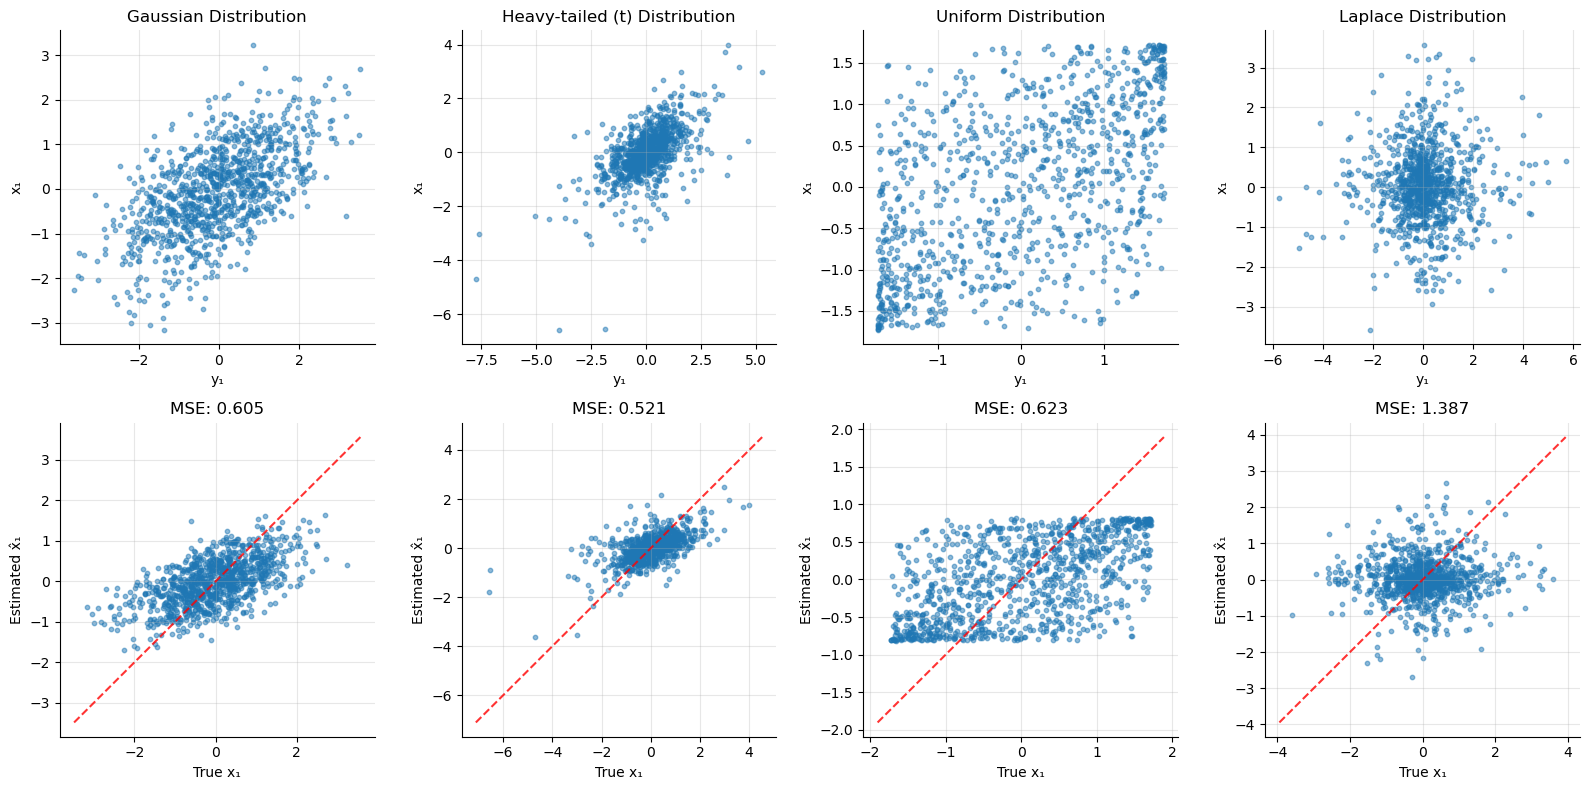

MMSE Performance Under Distribution Mismatch:
Theoretical minimum (Gaussian): 1.2407

Gaussian       : MSE = 0.6051 (0.49× optimal)
Heavy-tailed (t): MSE = 0.5214 (0.42× optimal)
Uniform        : MSE = 0.6232 (0.50× optimal)
Laplace        : MSE = 1.3868 (1.12× optimal)


In [6]:
def distribution_robustness():
    """Test MMSE performance under distribution mismatch"""
    
    # MMSE designed for Gaussian case
    mu_x = np.array([0, 0])
    mu_y = np.array([0, 0])
    K_xx = np.array([[1, 0.3], [0.3, 1]])
    K_yy = np.array([[1.5, 0.2], [0.2, 1.5]])
    K_xy = np.array([[0.7, 0.1], [0.2, 0.8]])
    
    gaussian_mmse = GaussianMMSE(mu_x, mu_y, K_xx, K_yy, K_xy)
    
    n_samples = 1000
    
    def generate_t_samples():
        """Generate samples from t-distribution (heavier tails)"""
        from scipy.stats import multivariate_t
        df = 3  # Low df = heavy tails
        
        # Joint covariance scaled for t-distribution
        K_joint = np.block([
            [K_xx, K_xy],
            [K_xy.T, K_yy]
        ]) * (df - 2) / df  # Scale for t-distribution
        
        mu_joint = np.concatenate([mu_x, mu_y])
        samples = multivariate_t.rvs(df=df, loc=mu_joint, shape=K_joint, size=n_samples)
        
        n_x = len(mu_x)
        return samples[:, :n_x], samples[:, n_x:]
    
    def generate_uniform_samples():
        """Generate uniform samples with same covariance structure"""
        # Generate Gaussian then transform to uniform
        X_gauss, Y_gauss = gaussian_mmse.sample_joint(n_samples)
        
        from scipy.stats import norm
        # Transform to uniform via CDF
        X_uniform = norm.cdf(X_gauss)
        Y_uniform = norm.cdf(Y_gauss)
        
        # Rescale to match original moments approximately
        X_uniform = (X_uniform - 0.5) * 3.46  # √12 ≈ 3.46 for unit variance
        Y_uniform = (Y_uniform - 0.5) * 3.46
        
        return X_uniform, Y_uniform
    
    def generate_laplace_samples():
        """Generate Laplace (double exponential) samples"""
        from scipy.stats import laplace
        
        # Independent Laplace samples
        X_indep = laplace.rvs(size=(n_samples, 2))
        Y_indep = laplace.rvs(size=(n_samples, 2))
        
        # Apply covariance structure
        L_x = np.linalg.cholesky(K_xx)
        L_y = np.linalg.cholesky(K_yy)
        
        X_corr = (X_indep @ L_x.T) / np.sqrt(2)  # Laplace has variance 2
        Y_corr = (Y_indep @ L_y.T) / np.sqrt(2)
        
        return X_corr + mu_x, Y_corr + mu_y
    
    distributions = {
        'Gaussian': lambda: gaussian_mmse.sample_joint(n_samples),
        'Heavy-tailed (t)': generate_t_samples,
        'Uniform': generate_uniform_samples,
        'Laplace': generate_laplace_samples
    }
    
    # Test each distribution
    results = {}
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for idx, (name, generator) in enumerate(distributions.items()):
        X_samples, Y_samples = generator()
        
        # Apply Gaussian MMSE (designed for case 1)
        X_hat = np.array([gaussian_mmse.estimate(y) for y in Y_samples])
        
        # Compute actual MSE
        mse_actual = np.mean((X_samples - X_hat)**2)
        results[name] = mse_actual
        
        # Plot data distribution
        ax = axes[0, idx]
        ax.scatter(Y_samples[:, 0], X_samples[:, 0], alpha=0.5, s=10)
        ax.set_xlabel('y₁')
        ax.set_ylabel('x₁')
        ax.set_title(f'{name} Distribution')
        ax.grid(True, alpha=0.3)
        
        # Plot estimation performance
        ax = axes[1, idx]
        ax.scatter(X_samples[:, 0], X_hat[:, 0], alpha=0.5, s=10)
        lims = [ax.get_xlim(), ax.get_ylim()]
        lims = [min(lims[0][0], lims[1][0]), max(lims[0][1], lims[1][1])]
        ax.plot(lims, lims, 'r--', alpha=0.8)
        ax.set_xlabel('True x₁')
        ax.set_ylabel('Estimated x̂₁')
        ax.set_title(f'MSE: {mse_actual:.3f}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("MMSE Performance Under Distribution Mismatch:")
    print(f"Theoretical minimum (Gaussian): {gaussian_mmse.mse_min:.4f}")
    print()
    for name, mse in results.items():
        ratio = mse / gaussian_mmse.mse_min
        print(f"{name:15s}: MSE = {mse:.4f} ({ratio:.2f}× optimal)")

distribution_robustness()